In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import transformers

import torch
import torchvision
from torchvision import transforms
import gc

from datasets import ImageDataLoader

# 1. Loading Pretrained Model&Tokenizers from Huggingface

In [4]:
model = transformers.CLIPModel.from_pretrained('openai/clip-vit-base-patch16')
tokenizer = transformers.CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [5]:
batch_size = 16
img_dir = '../data/train2017'
annot_dir = '../data/annotations/captions_train2017.json'

In [6]:
imageloader = ImageDataLoader(batch_size, img_dir, annot_dir)
table = imageloader.return_df()

# 2. Retrieval Engine

In [7]:
class TextImageRetrieval:
    def __init__(self, df, dataloader, clip, tokenizer):
        self.df = df
        self.dataloader = dataloader
        self.clip = clip
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize([.5,.5,.5],[.5,.5,.5])
            ])
        if os.path.isfile('coco_img_embs.pt'):
            print('There is precomputed embeddings')
            self.v_embs = torch.load('coco_img_embs.pt')
        else:
            self._compute_total_image_emb()

    def _compute_total_image_emb(self):
        embs = []
        print("Start Computing Image Embeddings")
        with torch.no_grad():
            for step, pixel_values in enumerate(self.dataloader):
                emb = self.clip.get_image_features(torch.Tensor(pixel_values.numpy()).permute(0,3,1,2))
                embs.append(emb)
                del emb
                gc.collect()
                # verbosity
                if (step+1)%10 == 0:
                    print('{} images processed'.format(int(self.dataloader.batch_size*(step+1))))
        print('Computation for Image embeddings is completed')
        self.v_embs = torch.cat(embs, dim=0)
        self.v_embs = self.v_embs / torch.norm(self.v_embs, dim=0)
        torch.save(self.v_embs, 'coco_img_embs.pt')
        del embs
        gc.collect()

    def query(self, img_path=None, text=None):
        # compute embedding of query(img or text or img+text)
        if img_path is None:
            tokens = self.tokenizer(text, max_length=76, padding='max_length', return_tensors='pt')
            q_emb = self.clip.get_text_features(**tokens)
        else:
            img = PIL.Image.open(img_path)
            pixel_values = self.transform(img).unsqueeze(0)
            tokens = self.tokenizer(text, max_length=76, padding='max_length', return_tensors='pt')
            q_emb = self.clip.get_text_features(**tokens) + self.clip.get_image_features(pixel_values)
        # find similar embedding using cosine_similarity
        q_emb = q_emb / torch.norm(q_emb, dim=0)
        cos_sim = torch.matmul(self.v_embs, torch.transpose(q_emb,0,1))
        idx = int(torch.argmax(cos_sim.squeeze(-1)))
        img = PIL.Image.open(self.df['image_path'][idx])
        plt.imshow(img)

In [8]:
t2iretrv = TextImageRetrieval(table, imageloader, model, tokenizer)

There is precomputed embeddings


# 3. Text to Image Retrieval
CLIP can retrieve most relevant image given arbitrary sentence. Let's see  how it works.

([], [])

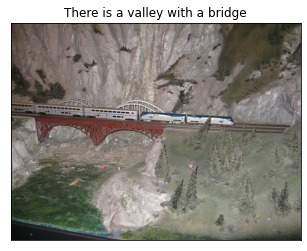

In [16]:
sentence = 'There is a valley with a bridge'
t2iretrv.query(text=sentence, img_path=None)
plt.title(sentence)
plt.xticks([])
plt.yticks([])

([], [])

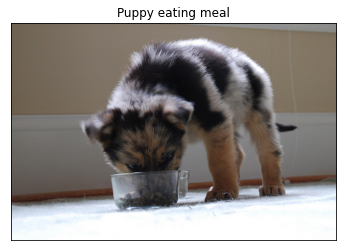

In [17]:
sentence = 'Puppy eating meal'
t2iretrv.query(text=sentence, img_path=None)
plt.title(sentence)
plt.xticks([])
plt.yticks([])

([], [])

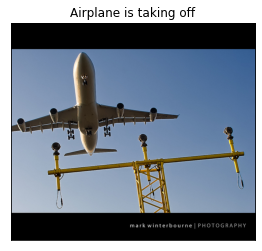

In [18]:
sentence = 'Airplane is taking off'
t2iretrv.query(text=sentence, img_path=None)
plt.title(sentence)
plt.xticks([])
plt.yticks([])

# 4. Text+Image to Image Retrieval

Given certain image and text, we can retrieve most relevant image by using ```Pretrained CLIP```. By just adding image embedding of image and text embedding of certain sentence, we can find most similar image from COCO2017 train image dataset. 

## 4.1. Demo 1

In this demo, let's see if CLIP can capture features related to color

First, there is image of teddy bear dall with brown color.

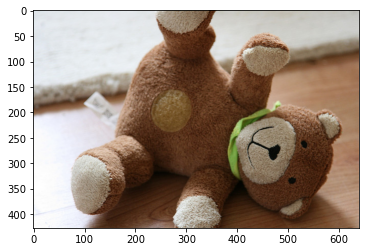

In [19]:
img_dir = '../data/test2017/000000000155.jpg'
img = PIL.Image.open(img_dir)
plt.imshow(img)

([], [])

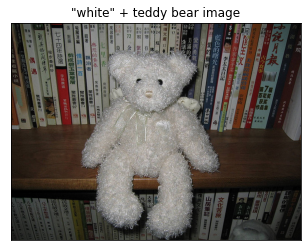

In [20]:
t2iretrv.query(text='white', img_path=img_dir)
plt.title('"white" + teddy bear image')
plt.xticks([])
plt.yticks([])

([], [])

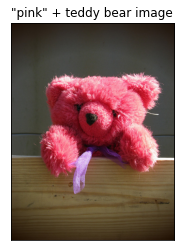

In [21]:
t2iretrv.query(text='pink', img_path=img_dir)
plt.title('"pink" + teddy bear image')
plt.xticks([])
plt.yticks([])

We can see that CLIP captures color related features from input text. <p> -1). image of brown teddy bear + 'pink' -> image of pink teddy bear<br> -2). image of brown teddy bear + 'white' -> image of white teddy bear

## 4.2. Demo 2
In this demo, let's see if CLIP captures feature related to certain object(dog, cloud...).

There is a man throwing frisbee in the park. Let's add text representation of 'dog'. <br> You can see that retrieved image represents dog catching frisbee in the park.

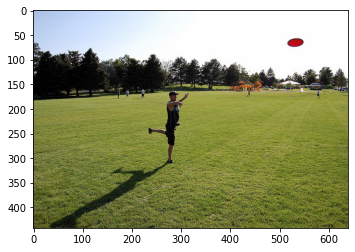

In [54]:
img_dir = '../data/test2017/000000004072.jpg'
img = PIL.Image.open(img_dir)
plt.imshow(img)

([], [])

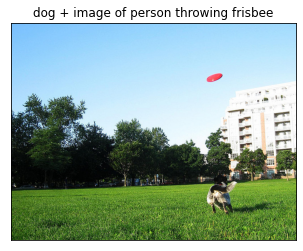

In [55]:
t2iretrv.query(text='dog', img_path=img_dir)
plt.title('"dog" + image of person throwing frisbee')
plt.xticks([])
plt.yticks([])

Next example, There is an image of airplane flying clear sky. Let's add text representation of 'clouds'.<br> We can see that retrieved image showing airplaine flying through cloudy sky.

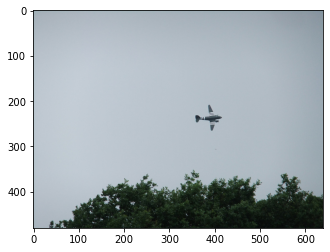

In [23]:
img_dir = '../data/test2017/000000021203.jpg'
img = PIL.Image.open(img_dir)
plt.imshow(img)

([], [])

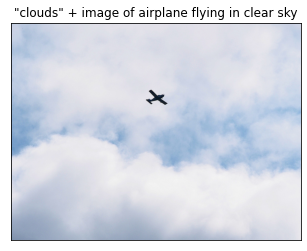

In [27]:
t2iretrv.query(text='cloud', img_path=img_dir)
plt.title('"clouds" + image of airplane flying in clear sky')
plt.xticks([])
plt.yticks([])

([], [])

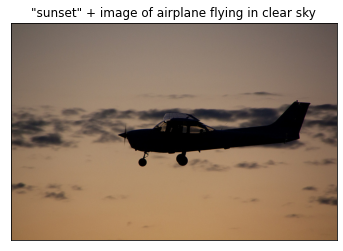

In [29]:
t2iretrv.query(text='sunset', img_path=img_dir)
plt.title('"sunset" + image of airplane flying in clear sky')
plt.xticks([])
plt.yticks([])